In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import regularizers, metrics
from keras import backend as K
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks",color_codes=True)
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [59]:
#data = np.loadtxt('input/CY5S_dist_all.dat')
data = np.loadtxt('input/A2_position.dat')
data = 1.0-data/np.max(data)

In [2]:
data = np.loadtxt('input/A2_position.dat')
pair = np.loadtxt('input/A2_position_names.dat',dtype='str')
data[:,0::3] = (data[:,0::3]-np.mean(data[:,0::3]))/np.std(data[:,0::3])
data[:,1::3] = (data[:,1::3]-np.mean(data[:,1::3]))/np.std(data[:,1::3])
data[:,2::3] = (data[:,2::3]-np.mean(data[:,2::3]))/np.std(data[:,2::3])
print(np.shape(data),data.max(),np.mean(data))

(100000, 24) 2.379651980205309 5.5469702905005154e-17


In [2]:
#helper function
import re
def read_Pycontact(file,pairID=False):
    with open(file,'r') as ins:
        data = []
        pair = []
        firstline = True
        for line in ins:
            if not firstline:
                line = line.rstrip('\n')
                tmp = re.findall( '\[(.*?)\]', line)[0].split(',')
                data.append([float(x) for x in tmp])
                if pairID:
                    tmp = line.split('[')[0].split()
                    pair.append((int(tmp[0]),int(tmp[2])))
                else:
                    pair.append(line.split('[')[0])
            else:
                firstline = False
    pair = np.asarray(pair)
    data = np.transpose(np.asarray(data))
    return pair, data

In [908]:
#villin data
clip_max = 1.
pair, data = read_Pycontact('input/villin_contact.txt')
print(data.max(),np.std(data),np.mean(data))
#mask = np.arange(np.shape(data)[0])[np.sum(data,axis=1)>0]
#data = (data[mask,:]-np.mean(data[mask,:]))/np.std(data[mask,:])

#normalized by std and clip
data = np.clip(data/np.std(data),0,clip_max)

#normalized by max
#data = data/np.max(data)



#try x/1+x to map to [0,1]
#data = data/(0.1+data)
print(np.shape(data),data.max(),np.mean(data))

22.19329614006301 0.9146377031367822 0.16528544578646867
(5843, 425) 1.0 0.051240086739379305


In [25]:
#imsize = (50,39)
imsize = (25,17) #villin resid contact
imsize = (8,3) #A2
mean_th = np.mean(data)
print(mean_th)
clip_max = 1.

5.5469702905005154e-17


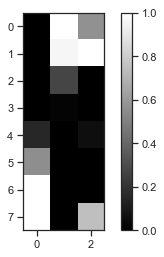

In [26]:
#plt.imshow(data[0].reshape(65,30))
plt.imshow(data[5000].reshape(imsize[0],imsize[1]))
plt.gray()
plt.colorbar()
plt.clim((0,clip_max))

In [27]:
def build_autoencoder(f_dim,encode_dim,latent_dim, sparse=10e-5, depth=1):

    input_data = Input(shape=(f_dim,))
    if sparse>0:
        sparse_regularizer = regularizers.l1(sparse)
    else:
        sparse_regularizer = None
        
    encoded = Dense(encode_dim, activation='relu', activity_regularizer=sparse_regularizer)(input_data)    
    for i in range(1,depth):
        encode_dim = encode_dim//2
        encoded = Dense(encode_dim, activation='relu', activity_regularizer=sparse_regularizer)(encoded)
    latent = Dense(latent_dim)(encoded)


    decoded = Dense(encode_dim, activation='relu')(latent)
    for i in range(1,depth): 
        encode_dim = encode_dim*2
        decoded = Dense(encode_dim, activation='relu')(decoded)
        
    decoded = Dense(f_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_data, decoded)

    encoder = Model(input_data, latent)

    # define decoder model
    #encoded_input= Input(shape=(latent_dim,))
    #encoded_input= Input(shape=(encode_dim,))
    #decoder_layer = autoencoder.layers[-1]
    #decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder, encoder

def build_autoencoder_conv(f_dim,encode_dim,latent_dim, filter_size = 5, depth=2):

    input_data = Input(shape=(f_dim,1))
        
    encoded = Conv1D(encode_dim, filter_size ,strides=2, activation='relu', padding='same')(input_data)    
    for i in range(1,depth):
        encode_dim = encode_dim//2
        encoded = MaxPooling1D(2, padding='same')
        encoded = Conv1D(encode_dim, filter_size, strides=2, activation='relu', padding='same')(encoded)
    encoded = Flatten()(encoded)    
    latent = Dense(latent_dim)(encoded)
    
    intm = f_dim
    for i in range(0,depth):
        intm_dim = (intm_dim-1)//2+1
    decoded = Dense(intm_dim, activation='relu')(latent)
    decoded = Reshape((intm_dim,1))
    
    for i in range(1,depth): 
        decoded = Conv1D(encode_dim, filter_size ,strides=2, activation='relu', padding='same')(decoded)
        decoded = UpSampling1D(2)
        encode_dim = encode_dim*2
            
    decoded = Conv1D(encode_dim, filter_size ,strides=2, activation='sigmoid', padding='same')(decoded)

    autoencoder = Model(input_data, decoded)

    encoder = Model(input_data, latent)

    # define decoder model
    #encoded_input= Input(shape=(latent_dim,))
    #encoded_input= Input(shape=(encode_dim,))
    #decoder_layer = autoencoder.layers[-1]
    #decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder, encoder

def focal_loss(gamma=2., alpha=.25, mean_th=0.5, clip_max=1.):
    #default paramemters in Lin et al. (2017)
    def focal_loss_eval(y_true, y_pred):
        pt_1 = tf.where(tf.greater_equal(y_true, mean_th), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.less(y_true, mean_th), y_pred, tf.zeros_like(y_pred))
        _epsilon = tf.convert_to_tensor(1e-7,dtype=y_pred.dtype.base_dtype)
        pt_1 = tf.clip_by_value(pt_1,_epsilon,clip_max-_epsilon)
        pt_0 = tf.clip_by_value(pt_0,_epsilon,clip_max-_epsilon)
        return  -K.sum(alpha * y_true * K.log(pt_1)) -K.sum((1-alpha) * (1-y_true) * K.log(1. - pt_0))
        #return -K.sum(alpha * y_true * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * (1-y_true)* K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_eval

In [28]:
f_dim = data.shape[1]
encode_dim = 8
latent_dim = 2
depth = 1
print(data.shape)
#clear previous model
K.clear_session()
autoencoder, encoder = build_autoencoder(f_dim, encode_dim, latent_dim, sparse=4e-5, depth=depth)

(100000, 24)


In [29]:
#autoencoder.compile(optimizer='adam',loss='binary_crossentropy',metrics=['mse'])
autoencoder.compile(optimizer='adam',loss='mse',metrics=['mse'])
#autoencoder.compile(optimizer='adam',loss=[focal_loss(gamma=2.0,alpha=0.5,mean_th=mean_th,clip_max=clip_max)],metrics=['mse'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 200       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 24)                216       
Total params: 458
Trainable params: 458
Non-trainable params: 0
_________________________________________________________________


In [30]:
x_train, x_test, _, _ = train_test_split(data,data, test_size=0.2)

In [31]:
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.003,patience=10,verbose=2)
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=32, shuffle=True, validation_data=(x_test, x_test),
                         verbose=2,callbacks=[early_stop])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
 - 13s - loss: 0.5767 - mean_squared_error: 0.5670 - val_loss: 0.5345 - val_mean_squared_error: 0.5312
Epoch 2/100
 - 6s - loss: 0.5305 - mean_squared_error: 0.5282 - val_loss: 0.5293 - val_mean_squared_error: 0.5277
Epoch 3/100
 - 7s - loss: 0.5285 - mean_squared_error: 0.5271 - val_loss: 0.5284 - val_mean_squared_error: 0.5273
Epoch 4/100
 - 6s - loss: 0.5277 - mean_squared_error: 0.5267 - val_loss: 0.5277 - val_mean_squared_error: 0.5269
Epoch 5/100
 - 7s - loss: 0.5272 - mean_squared_error: 0.5265 - val_loss: 0.5274 - val_mean_squared_error: 0.5267
Epoch 6/100
 - 7s - loss: 0.5269 - mean_squared_error: 0.5263 - val_loss: 0.5273 - val_mean_squared_error: 0.5268
Epoch 7/100
 - 7s - loss: 0.5266 - mean_squared_error: 0.5261 - val_loss: 0.5269 - val_mean_squared_error: 0.5264
Epoch 8/100
 - 7s - loss: 0.5265 - mean_squared_error: 0.5260 - val_loss: 0.5269 - val_mean_squared_error: 0.5265
Epoch 9/100
 - 7s - loss: 0.5264 - me

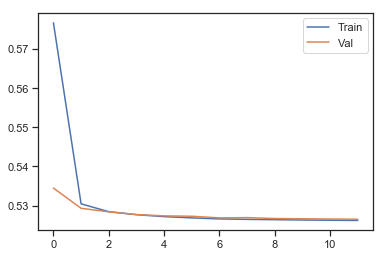

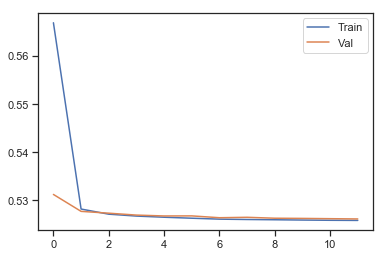

In [33]:
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Val')
plt.legend()
plt.figure()
plt.plot(history.history['mean_squared_error'],label='Train')
plt.plot(history.history['val_mean_squared_error'],label='Val')
plt.legend()

In [36]:
def prediction_error(y_true,y_pred,mean_th):
    rmse = np.sqrt(np.mean(np.square(y_true-y_pred)))
    y_true = np.where(y_true>mean_th, np.ones(np.shape(y_true)), np.zeros(np.shape(y_true)))
    y_pred = np.where(y_pred>mean_th, np.ones(np.shape(y_pred)), np.zeros(np.shape(y_pred)))
    return np.mean(np.abs(y_true-y_pred)) , rmse

In [34]:
output = autoencoder.predict(data)
cv = encoder.predict(data)
cols = ['CV'+str(i) for i in range(1,latent_dim+1)]
cv_pd = pd.DataFrame(cv, columns=cols)
cv_pd.describe()

,CV1,CV2
count,100000.000000,100000.000000
mean,-0.453376,-0.954971
std,0.566867,0.589128
min,-2.090769,-3.491775
25%,-0.968181,-1.355119
50%,-0.340687,-0.919308
75%,-0.014877,-0.557585
max,0.893847,1.340191


prediction error =  (0.4583333333333333, 0.7086122635398416)
highest 5 contacts: [21  1  4 18  2  5 15  7 11 12  8 13 23  6 10 22 20 14  3 16] [ 1.77332757  1.59421961  1.39304806  1.29901588  1.16202695  0.98499058
  0.49322951  0.2635853   0.25588389  0.2169982   0.14599619  0.14029234
  0.09717687 -0.53880204 -0.55519359 -0.59860136 -0.63050987 -0.63789571
 -0.7751799  -0.87522724]
predicted 5 contacts: [21  1 18  5  4  2 15  8 13 11 12  7 23  9 10 20  6  3 19 17] [1.0000000e+00 1.0000000e+00 1.0000000e+00 9.9990809e-01 9.9940395e-01
 7.9754019e-01 5.4414564e-01 1.8027696e-01 1.6112299e-01 1.4002411e-01
 4.9964882e-02 4.5312312e-02 2.2415167e-02 1.7040940e-11 4.7690575e-12
 3.5970116e-12 1.0950071e-12 9.0363638e-13 2.2012666e-13 1.4077576e-13]


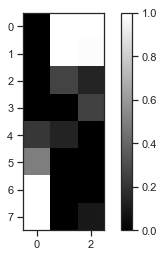

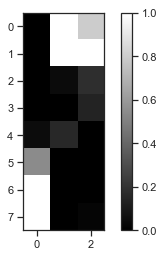

<Figure size 432x288 with 0 Axes>

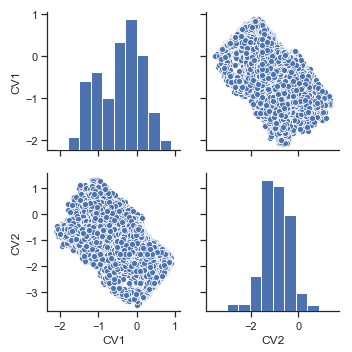

In [37]:
example = 4000

plt.imshow(data[example].reshape(imsize[0],imsize[1]))
plt.gray()
plt.colorbar()
plt.clim(0,clip_max)
plt.figure()
plt.imshow(output[example].reshape(imsize[0],imsize[1]))
plt.gray()
plt.clim(0,clip_max)
plt.colorbar()
plt.figure()
sns.pairplot(cv_pd)
print('prediction error = ',prediction_error(data[example],output[example],mean_th))
rank = np.argsort(data[example])[::-1][0:20]
rank_pred = np.argsort(output[example])[::-1][0:20]
print('highest 5 contacts:',rank,data[example][rank])
print('predicted 5 contacts:',rank_pred,output[example][rank_pred])

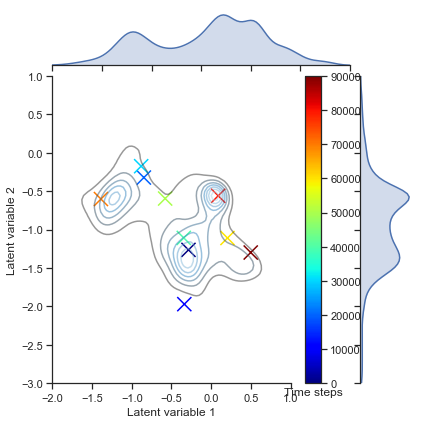

In [57]:
mid , late = 3000, 5830; #villin
#mid , late = 4000, 8000
frame = np.linspace(0,90000,10)
if np.shape(cv_pd)[1]>1:
    g = sns.JointGrid(x=cv_pd['CV1'].iloc[::10],y=cv_pd['CV2'].iloc[::10],xlim=(-2,1),ylim=(-3,1))
    g = g.plot_joint(sns.kdeplot, cmap='Blues_d',alpha=0.5)
    plt.scatter(cv_pd['CV1'][frame],cv_pd['CV2'][frame],c=frame,marker='x',s=200,cmap='jet')
    #plt.scatter(cv_pd['CV1'][mid],cv_pd['CV2'][mid],c='g',marker='x',s=200)
    #plt.scatter(cv_pd['CV1'][late],cv_pd['CV2'][late],c='r',marker='x',s=200)
    plt.xlabel('Latent variable 1')
    plt.ylabel('Latent variable 2')
    c = plt.colorbar()
    c.ax.set_xlabel('Time steps')
    g = g.plot_marginals(sns.kdeplot, shade=True)
    fig = plt.gcf()
    fig.savefig('figs/A2_model-8-2CV.png',dpi=100)
else:
    fig = plt.figure(figsize=(8,5))
    plt.xlabel('Latent variable')
    plt.ylabel('Counts')
    plt.hist(cv_pd['CV1'],bins=np.linspace(-50,20,21),alpha=0.3)
    plt.scatter(cv_pd['CV1'][100],0,c='k',marker='x')
    plt.scatter(cv_pd['CV1'][mid],0,c='g',marker='x')
    plt.scatter(cv_pd['CV1'][late],0,c='r',marker='x')
    plt.scatter(cv_pd['CV1'],200+np.zeros((1,len(cv_pd['CV1']))),c=np.arange(len(cv_pd['CV1'])),cmap='jet')
    plt.colorbar()    
    #fig.savefig('figs/villin_model-200-1CV-CE.png',dpi=100)

In [84]:
print('Variance explained = ',[cv_pd['CV1'].var(),cv_pd['CV2'].var()]/np.sum(np.var(data,axis=0)))
print('Reconstructed var = ',np.sum(np.var(output,axis=0))/np.sum(np.var(data,axis=0)))
print(np.sum(np.var(output,axis=0)))

Variance explained =  [0.08132454 0.08783714]
Reconstructed var =  0.1204122205977862
0.47578573


In [56]:
autoencoder.save_weights('models/A2-8-full-CV2.h5')
encoder.save_weights('models/A2-8-encode-CV2.h5')

In [973]:
from keras.models import load_model
autoencoder = load_model('models/Villin-200-full-CV1CE.h5')
encoder = load_model('models/Villin-200-full-CV1CE.h5')

ValueError: Unknown loss function:focal_loss_eval

In [743]:
class ActivationMaximization(object):
    def __init__(self, layer, filter_indices):
        self.name = "Activation Max Loss"
        self.layer = layer
        self.filter_indices = filter_indices #list object
    def build_loss(self):
        layer_output = self.layer.output
        
        loss = 0.
        for idx in self.filter_indices:
            loss += -K.mean(layer_output[:,idx])
        
        return loss
            
class Optimizer(object):
    def __init__(self, input_tensor, losses, norm_grads=True):
        self.input_tensor = input_tensor
        self.loss_names = []
        self.loss_functions = []
        self.wrt_tensor = K.identity(self.input_tensor)
        overall_loss = None
        for loss, weight in losses:
            if weight!=0:
                loss_fn = weight * loss.build_loss()
                overall_loss = loss_fn if overall_loss is None else overall_loss + loss_fn
                self.loss_names.append(loss.name)
                self.loss_functions.append(loss_fn)
        grads = K.gradients(overall_loss, self.input_tensor)[0]
        if norm_grads:
            grads = K.l2_normalize(grads)
        self.compute_fn = K.function([self.input_tensor, K.learning_phase()],
                                    self.loss_functions + [overall_loss, grads, self.wrt_tensor])
        
    def _rmsprop(self, grads, cache=None, decay_rate=0.95):
        if cache is None:
            cache = np.zeros_like(grads)
        cache = decay_rate * cache + (1 - decay_rate) * grads ** 2
        # -grad means minimize loss function
        step = -grads / np.sqrt(cache + K.epsilon())
        return step, cache

    def _get_seed_input(self, seed_input):
        desired_shape = (1, ) + K.int_shape(self.input_tensor)[1:]

        # seed_input cannot be None
        # Add batch dim if needed.
        if len(seed_input.shape) != len(desired_shape):
            seed_input = np.expand_dims(seed_input, 0)

        return seed_input.astype(K.floatx())
    
    



    def minimize(self, seed_input, max_iter=200,
                 grad_modifier=None,
                 callbacks=None, verbose=True):

        seed_input = self._get_seed_input(seed_input)
        
        def relu(grads):
            grads[grads < 0.] = 0.
            return grads
        
        def absolute(grads):
            return np.abs(grads)
        
        def deprocess_input(input_array, input_range=(0, 1)):
            # normalize tensor: center on 0., ensure std is 0.1
            input_array = input_array.copy()
            input_array -= input_array.mean()
            input_array /= (input_array.std() + K.epsilon())
            input_array *= 0.1

            # clip to [0, 1]
            input_array += 0.5
            #input_array = np.clip(input_array, 0, 1)

            # Convert to `input_range`
            return (input_range[1] - input_range[0]) * input_array + input_range[0]
    
        #try absolute for maximal change
        grad_modifier = locals()[grad_modifier]

        callbacks = callbacks or []
        #if verbose:
        #    callbacks.append(_PRINT_CALLBACK)

        cache = None
        best_loss = float('inf')
        best_input = None

        grads = None
        wrt_value = None

        for i in range(max_iter):
            # 0 learning phase for 'test'
            computed_values = self.compute_fn([seed_input, 0])
            losses = computed_values[:len(self.loss_names)]
            named_losses = list(zip(self.loss_names, losses))
            overall_loss, grads, wrt_value = computed_values[len(self.loss_names):]

            # TODO: theano grads shape is inconsistent for some reason. Patch for now and investigate later.
            if grads.shape != wrt_value.shape:
                grads = np.reshape(grads, wrt_value.shape)
                
            # Apply grad modifier.
            grads = grad_modifier(grads)

            # Trigger callbacks
            for c in callbacks:
                c.callback(i, named_losses, overall_loss, grads, wrt_value)

            # Gradient descent update.
            # It only makes sense to do this if wrt_tensor is input_tensor. Otherwise shapes wont match for the update.
            step, cache = self._rmsprop(grads, cache)
            seed_input += step

            if overall_loss < best_loss:
                best_loss = overall_loss.copy()
                best_input = seed_input.copy()

        # Trigger on_end
        for c in callbacks:
            c.on_end()

        return deprocess_input(best_input[0]), grads, wrt_value

def normalize(array, min_value=0., max_value=1.):
    arr_min = np.min(array)
    arr_max = np.max(array)
    normalized = (array - arr_min) / (arr_max - arr_min + K.epsilon())
    return (max_value - min_value) * normalized + min_value
    

def visualize_saliency(model, layer_idx, filter_indices, seed_input, grad_modifier='absolute',max_iter=100):
    input_tensor = model.input
    losses = [(ActivationMaximization(encoder.layers[layer_idx],filter_indices),1)]
    opt = Optimizer(input_tensor, losses, norm_grads=False)
    grads = opt.minimize(seed_input=seed_input, max_iter=max_iter, grad_modifier=grad_modifier)
    return grads

best input: ['              64 - 51  ' '              63 - 55  '
 '              75 - 62  ' '              67 - 62  '
 '              75 - 61  ' '              57 - 50  '
 '              63 - 54  ' '              58 - 47  '
 '              63 - 51  ' '              75 - 67  '
 '              76 - 61  ' '              57 - 47  '
 '              73 - 67  ' '              47 - 42  '
 '              57 - 42  ' '              76 - 59  '
 '              72 - 67  ' '              74 - 67  '
 '              56 - 51  ' '              63 - 56  '
 '              67 - 44  ' '              75 - 54  '
 '              67 - 57  ' '              75 - 49  '
 '              74 - 49  ' '              71 - 45  '
 '              74 - 54  ' '              50 - 42  '
 '              74 - 51  ' '              73 - 55  ']
best input magnitude: [0.76569915 0.7489289  0.7403685  0.73659813 0.7299758  0.7218257
 0.70097136 0.69792587 0.6978569  0.6912118  0.67423457 0.66942865
 0.660185   0.65804046 0.65146863 0.6

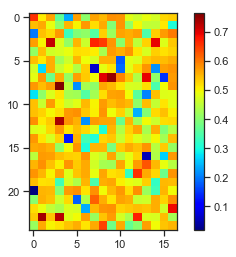

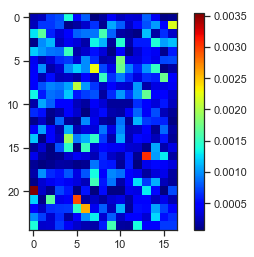

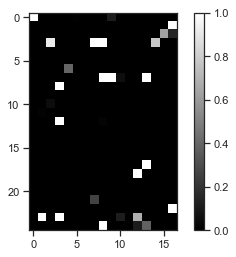

In [1023]:
layer_idx = 2
filter_indices = [0]
grads = visualize_saliency(encoder, layer_idx, filter_indices, x_test, grad_modifier='absolute',max_iter=1)

rank = (np.argsort(grads[0],axis=0))[::-1]
print('best input:',pair[rank[0:30]])
print('best input magnitude:',grads[0][rank[0:30]])
plt.imshow(grads[0].reshape(imsize[0],imsize[1]),cmap='jet')
plt.colorbar()
#plt.clim(0,1)
plt.figure()
plt.imshow(np.mean(grads[1],axis=0).reshape(imsize[0],imsize[1]),cmap='jet')
rank = (np.argsort(np.mean(grads[1],axis=0)))[::-1]
print('gradient:',pair[rank[0:10]])
plt.colorbar()
plt.figure()
plt.imshow(grads[2][0].reshape(imsize[0],imsize[1]))
plt.colorbar()
plt.clim(0,1)

# villin pairs
best input: ['              55 - 44  ' '              61 - 53  '
 '              54 - 47  ' '              55 - 50  '
 '              67 - 46  ' '              56 - 46  '
 '              68 - 46  ' '              67 - 61  '
 '              74 - 43  ' '              74 - 55  '
 '              70 - 50  ' '              68 - 45  '
 '              60 - 42  ' '              75 - 62  '
 '              63 - 52  ' '              71 - 60  '
 '              70 - 43  ' '              52 - 42  '
 '              59 - 46  ' '              71 - 51  '
 '              67 - 52  ' '              63 - 57  '
 '              63 - 53  ' '              68 - 44  '
 '              75 - 65  ' '              72 - 55  '
 '              74 - 56  ' '              52 - 44  '
 '              73 - 47  ' '              62 - 44  ']
best input magnitude: [0.7181001  0.71788394 0.6400813  0.6280649  0.62715864 0.6269273
 0.6267277  0.62638634 0.62632483 0.62553906 0.62510705 0.62497926
 0.6245422  0.6238376  0.6233958  0.6231452  0.62305295 0.6229271
 0.6228719  0.622804   0.6226403  0.62240285 0.6223074  0.6222532
 0.6210997  0.619982   0.61970556 0.6191561  0.6183428  0.618213  ]
# CY5    
    best input: [' nm. N - nm. O21 , s. MEMB  ' ' nm. CN5 - nm. C2 , s. MEMB  '
 ' nm. SM - nm. O21 , s. MEMB  ' ' nm. CB - nm. O14 , s. MEMB  '
 ' nm. N - nm. C11 , s. MEMB  ' ' nm. CD3 - nm. C24 , s. MEMB  '
 ' nm. CN3 - nm. O12 , s. MEMB  ' ' nm. CN3 - nm. C12 , s. MEMB  '
 ' nm. CY - nm. C24 , s. MEMB  ' ' nm. CAA - nm. C3T , s. MEMB  ']
best input magnitude: [0.8297647  0.8295579  0.8290258  0.8286811  0.8276938  0.82536435
 0.82495666 0.8243901  0.82397234 0.8239261 ]

# Comparison with other methods

In [7]:
import MDAnalysis as mda
import MDAnalysis.analysis.pca as pca
from sklearn.decomposition import PCA

In [65]:
dihed = np.loadtxt('input/dihed_A2.dat')
cols = ['phi1','psi1','phi2','psi2']
dihed = pd.DataFrame(dihed, columns=cols)
dihed.describe()

,phi1,psi1,phi2,psi2
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,-83.748733,77.500643,-84.174900,86.098409
std,42.645460,86.005278,46.893674,84.497485
min,-179.962616,-179.991730,-179.994446,-179.999451
25%,-107.605965,-1.272599,-111.969482,8.015183
50%,-81.659889,128.234176,-83.907776,132.833183
75%,-63.002655,147.951477,-63.340083,149.399395
max,179.955444,179.993713,179.957565,179.991150


In [13]:
pca = PCA(n_components=2)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [88]:
data2 = data-np.mean(data,axis=0)


(100000, 24)

In [72]:
print(pca.explained_variance_ratio_,pca.singular_values_)

[0.3927699 0.2160169] [393.94856428 292.15564854]


In [17]:
data_pc = pca.transform(data)
cols = ['PC'+str(i) for i in range(1,3)]
pc_pd = pd.DataFrame(data_pc, columns=cols)
pc_pd.describe()

,PC1,PC2
count,1.000000e+05,1.000000e+05
mean,-1.486455e-15,3.024070e-16
std,1.245781e+00,9.238819e-01
min,-2.398323e+00,-2.119538e+00
25%,-1.153621e+00,-5.874856e-01
50%,1.970876e-01,1.521729e-02
75%,8.851989e-01,5.056897e-01
max,2.865329e+00,4.552128e+00


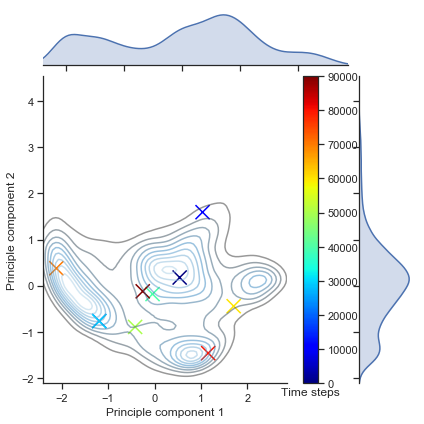

In [63]:
frame = np.linspace(0,90000,10)
xlim=(pc_pd['PC1'].min(),pc_pd['PC1'].max())
ylim=(pc_pd['PC2'].min(),pc_pd['PC2'].max())
g = sns.JointGrid(x=pc_pd['PC1'].iloc[::10],y=pc_pd['PC2'].iloc[::10],xlim=xlim,ylim=ylim)
g = g.plot_joint(sns.kdeplot, cmap='Blues_d',alpha=0.5)
plt.scatter(pc_pd['PC1'][frame],pc_pd['PC2'][frame],c=frame,marker='x',s=200,cmap='jet')
plt.xlabel('Principle component 1')
plt.ylabel('Principle component 2')
c = plt.colorbar()
c.ax.set_xlabel('Time steps')
g = g.plot_marginals(sns.kdeplot, shade=True)
fig = plt.gcf()
#fig.savefig('figs/A2_pca.png',dpi=100)

In [71]:
pc_pd['PC1'].var()/sum(pc_pd.var())

0.6451682266812323

0.39277382515985765


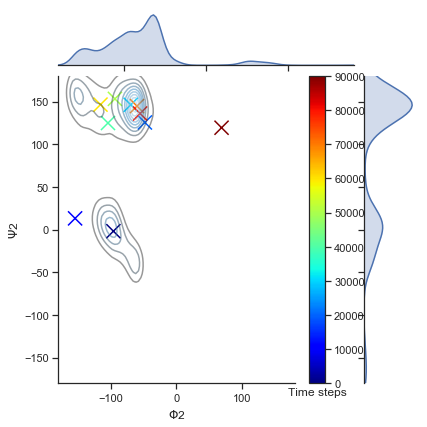

In [68]:
frame = np.linspace(0,90000,10)
g = sns.JointGrid(x=dihed['phi2'].iloc[::10],y=dihed['psi2'].iloc[::10],xlim=(-180,180),ylim=(-180,180))
g = g.plot_joint(sns.kdeplot, cmap='Blues_d',alpha=0.5)
plt.scatter(dihed['phi2'][frame],dihed['psi2'][frame],c=frame,marker='x',s=200,cmap='jet')
plt.xlabel(r'$\Phi$2')
plt.ylabel(r'$\Psi$2')
c = plt.colorbar()
c.ax.set_xlabel('Time steps')
g = g.plot_marginals(sns.kdeplot, shade=True)
fig = plt.gcf()
fig.savefig('figs/A2_dihed2.png',dpi=100)